In [1]:
# モデル作成に使用するライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# よく使用するライブラリ
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)

# gpuの指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# クラスの定義
class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)

    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        return y, z

    def reparameterize(self, mean, var):
        z = mean + torch.sqrt(var) * torch.randn(mean.size()).to(self.device)
        return z

    def criterion(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        L1 =  - torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y), dim=1))
        # この比率 (今回でいうと -1/200 ) がハイパーパラメータで最初少し苦労した．
        L2 = - 1/200 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))
        L =  L1 + L2

        return L

class Encoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(1, 5)
        self.l2 = nn.Linear(5, 5)
        self.l_mean = nn.Linear(5, 1)
        self.l_var = nn.Linear(5, 1)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)
        mean = self.l_mean(h)
        var = self.l_var(h)
        var = F.softplus(var)

        return mean, var

class Decoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(1, 5)
        self.l2 = nn.Linear(5, 5)
        self.out = nn.Linear(5, 1)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.sigmoid(h)

        return y

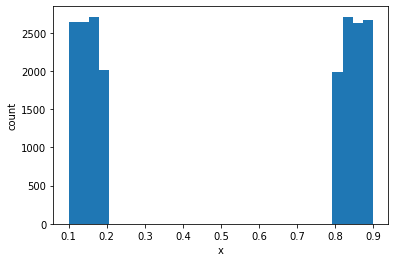

Epoch: 1, Loss: 0.7083388507366181
Epoch: 21, Loss: 0.4799012318253517
Epoch: 41, Loss: 0.4377932533621788
Epoch: 61, Loss: 0.4366608798503876
Epoch: 81, Loss: 0.43643855303525925
Epoch: 101, Loss: 0.43604612797498704
Epoch: 121, Loss: 0.43626767098903657
Epoch: 141, Loss: 0.4361070305109024
Epoch: 161, Loss: 0.4358620122075081
Epoch: 181, Loss: 0.43593480437994003
Epoch: 201, Loss: 0.43556035310029984
Epoch: 221, Loss: 0.4356132671236992
Epoch: 241, Loss: 0.43558935821056366
Epoch: 261, Loss: 0.4356038272380829
Epoch: 281, Loss: 0.43583598732948303
Epoch: 301, Loss: 0.43566723465919494
Epoch: 321, Loss: 0.435666686296463
Epoch: 341, Loss: 0.43548864424228667
Epoch: 361, Loss: 0.43569688498973846
Epoch: 381, Loss: 0.43553660064935684
Epoch: 401, Loss: 0.4353303983807564
Epoch: 421, Loss: 0.4358798786997795
Epoch: 441, Loss: 0.4356972098350525
Epoch: 461, Loss: 0.43529178351163866
Epoch: 481, Loss: 0.4357385292649269


In [7]:
# データの例１
data1 = torch.rand(10000,1)
data1 = data1 / 10 + 1/10

data2 = torch.rand(10000,1)
data2 = data2 / 10 + 8/10

data = torch.cat((data1, data2), dim=0)

data_np = data.squeeze().detach().cpu().numpy()

# データの可視化
plt.hist(data_np, bins=30)
plt.xlabel('x')
plt.ylabel('count')
plt.show()


batch_size = 1000
train_loader = torch.utils.data.DataLoader(data, batch_size, shuffle=True)



# モデルのインスタンス作って学習
model = VAE(device=device).to(device)
criterion = model.criterion
optimizer = optim.Adam(model.parameters())

n_epoch = 500

for epoch in range(n_epoch):
    loss_mean = 0.
    for x in train_loader:

      # 学習準備
      x = x.to(device)
      model.train()
      
      # モデルの学習
      loss = criterion(x)
      optimizer.zero_grad()
      loss.backward()     
      optimizer.step()

      # 損失関数の計算
      loss_mean += loss.item()
    loss_mean /= len(train_loader)

    if epoch % 20 == 0:
      print(f"Epoch: {epoch+1}, Loss: {loss_mean}")

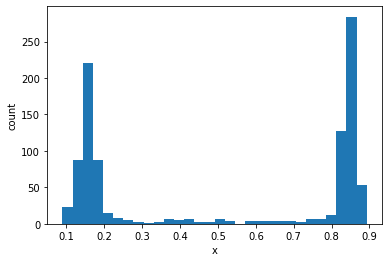

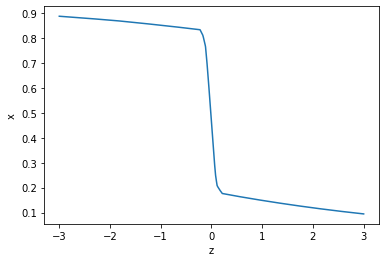

In [8]:
# 特徴量空間 z において一次元正規分布からサンプルを取り，デコーダーでもとに戻す．
model.eval()
z = torch.randn(1000, 1, device = device)
x = model.decoder(z)
x = x.view(-1, 1, 1)
x = x.squeeze().detach().cpu().numpy()

# データの可視化
plt.hist(x, bins=30)
plt.xlabel('x')
plt.ylabel('count')
plt.show()





# 特徴量空間 z の[-3,+3]が，デコーダーで戻すとどうなるか．
num_z = 1000

# 潜在変数の作成
z = torch.linspace(-3, 3, num_z)
z = z.reshape(num_z, -1)

x = model.decoder(z)
x = x.view(-1, 1, 1)
x = x.squeeze().detach().cpu().numpy()

# データの可視化
plt.plot(z, x)
plt.xlabel('z')
plt.ylabel('x')
plt.show()